In [1]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import plotly.express as px

CSV = "club_dataset_public.csv"   
df = pd.read_csv(CSV)

In [2]:
# Quick look at what we got (counts of missing values per column)
print("Missing values:\n", df.isna().sum(), "\n")
print(df.dtypes)

Missing values:
 shortcode      0
post_url       0
date_utc       0
likes          0
comments       0
is_video       0
caption        0
hashtags       5
hour           0
day            0
n_hashtags     0
caption_len    0
engagement     0
dtype: int64 

shortcode       object
post_url        object
date_utc        object
likes            int64
comments         int64
is_video          bool
caption         object
hashtags       float64
hour             int64
day             object
n_hashtags       int64
caption_len      int64
engagement       int64
dtype: object


In [3]:
# Decide what NOT to use in analysis 
# Keep reference-only fields out of math/correlations (we still keep them in df for reference)
drop_from_model = ["post_url"]        # URLs not useful for stats
df = df.drop(columns=drop_from_model, errors="ignore")


In [4]:
# Keep only rows that have CRITICAL fields 
# For your dataset, these are the must-haves:
# - shortcode (id) - to dedupe
# - date_utc       - to compute time-based features
# - likes/comments - to compute engagement
must_have = ["shortcode", "date_utc", "likes", "comments"]
df = df.dropna(subset=must_have)   # <-- dont' drop rows just because caption/hashtags are null

In [5]:
# Fix types & fill optional text fields 
# Likes/comments should be numeric; caption/hashtags can be empty strings.
df["likes"] = pd.to_numeric(df["likes"], errors="coerce").fillna(0).astype("int64")
df["comments"] = pd.to_numeric(df["comments"], errors="coerce").fillna(0).astype("int64")
df["caption"] = df["caption"].fillna("")
df["hashtags"] = df["hashtags"].fillna("")


In [6]:
# Some collectors may store booleans as strings; make is_video consistent if present
if "is_video" in df.columns:
    df["is_video"] = df["is_video"].astype(bool)

In [7]:
# Parse dates & add the same time features you used before 
# Parse to timezone-aware UTC, drop rows where date is unparsable.
df["date_utc"] = pd.to_datetime(df["date_utc"], utc=True, errors="coerce")
df = df.dropna(subset=["date_utc"])

In [8]:
# Convert to your local timezone for hour/day analysis (change tz if needed)
df["local_dt"] = df["date_utc"].dt.tz_convert("US/Pacific")
df["hour"] = df["local_dt"].dt.hour
df["day"] = df["local_dt"].dt.day_name()

In [9]:
# Engineer analysis features 
# Engagement like in the tutorial
df["engagement"] = df["likes"] + df["comments"]

In [10]:
# Hashtag count: if non-empty there is at least 1 hashtag; commas separate additional tags.
df["n_hashtags"] = (df["hashtags"] != "").astype(int) + df["hashtags"].str.count(",")

In [11]:
# Caption length for text/wordcloud comparisons
df["caption_len"] = df["caption"].str.len()

In [12]:
# De-duplicate posts 
# If the same post was seen multiple times, keep the latest record.
df = df.drop_duplicates(subset="shortcode", keep="last")

In [13]:
# Final sanity filters (optional)
# Remove impossible values if any slipped through
df = df[(df["likes"] >= 0) & (df["comments"] >= 0)]

print("Rows after cleaning:", len(df))
df.head()

Rows after cleaning: 5


,shortcode,date_utc,likes,comments,is_video,caption,hashtags,hour,day,n_hashtags,caption_len,engagement,local_dt
0,ChX5v4APvuq,2022-08-17 20:08:37+00:00,24,0,False,Welcome to the Fall semester of 2022! 🎉 Glad ...,,13,Wednesday,0,303,24,2022-08-17 13:08:37-07:00
1,DOWvH8oEjNZ,2025-09-08 20:49:17+00:00,14,0,False,"This Wednesday, 2pm-3pm, in the Student Union ...",,13,Monday,0,416,14,2025-09-08 13:49:17-07:00
2,DOZK5N4kk9U,2025-09-09 19:30:25+00:00,14,0,False,"This Friday, 12pm-1:30pm, in the BBC 103: Work...",,12,Tuesday,0,337,14,2025-09-09 12:30:25-07:00
3,DOhpF-dkdRB,2025-09-13 02:28:14+00:00,55,0,False,Join us for the AI & Fraud Case Challenge! 💥 ...,,19,Friday,0,206,55,2025-09-12 19:28:14-07:00
4,DOpETbSkhGa,2025-09-15 23:40:41+00:00,11,0,False,Workshop on PyTorch: Train your Own AI Model ...,,16,Monday,0,285,11,2025-09-15 16:40:41-07:00


In [14]:
## Using only relevant columns in comparisons/correlations

num = df.select_dtypes(include="number")
corr = num.corr()
corr["engagement"].sort_values(ascending=False)


likes          1.000000
engagement     1.000000
hour           0.762603
caption_len   -0.757643
comments            NaN
n_hashtags          NaN
Name: engagement, dtype: float64

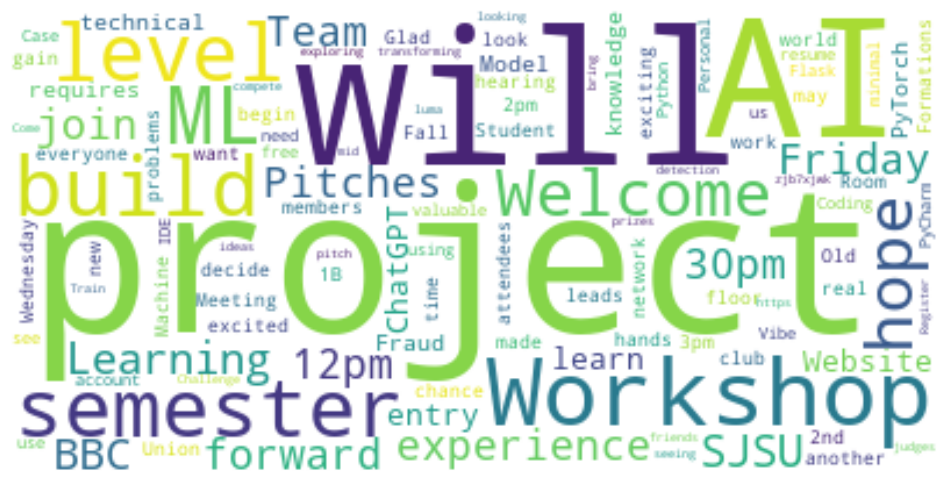

In [15]:
# Wordclouds without null headaches

text = " ".join(df["caption"].astype(str))
wc = WordCloud(stopwords=set(STOPWORDS), background_color="white").generate(text)
plt.figure(figsize=(12, 8)); plt.imshow(wc, interpolation="bilinear"); plt.axis("off"); plt.show()


In [16]:
# Plotly scatter examples (like the tutorial)

px.scatter(df, x="engagement", y="n_hashtags", trendline="ols",
           title="Engagement vs Hashtag Count").show()

px.scatter(df, x="likes", y="comments", trendline="ols",
           title="Likes vs Comments").show()


/Users/kenan/Desktop/projects/instagram-reach-analysis/.venv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


/Users/kenan/Desktop/projects/instagram-reach-analysis/.venv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

invalid value encountered in scalar divide



In [17]:
df = pd.read_csv("club_dataset_public.csv")

In [18]:
# Likes distribution
px.histogram(df, x="likes", nbins=30, title="Distribution of Likes").show()


In [19]:

# Engagement distribution
if "engagement" not in df.columns:
    df["engagement"] = df["likes"] + df["comments"]
px.histogram(df, x="engagement", nbins=30, title="Distribution of Engagement").show()

In [20]:

# Engagement by hour/day if you added time features 'hour' and 'day'
# (see earlier cell I gave you to parse date & add hour/day)
if {"hour","day"}.issubset(df.columns):
    px.box(df, x="day", y="engagement", points="all",
           title="Engagement by Day of Week").show()
    px.box(df, x="hour", y="engagement", points="all",
           title="Engagement by Hour of Day").show()
